In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
%matplotlib inline

import numpy as np
import autoreject
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import mne
import os
import sys
from atpbar import atpbar
import glob
from mne.stats import permutation_cluster_test
from scipy.stats import ttest_rel
from mne.channels import make_standard_montage
from mne.viz import plot_topomap
from mne.stats import permutation_cluster_1samp_test


In [2]:
# Suppress MNE output
#mne.set_log_level('WARNING')
mne.set_log_level('ERROR')
#mne.set_log_level('CRITICAL')
#mne.set_log_level('INFO')



## Visualisation to test for outliers

In [3]:
# # loop to check each individual response and see which ones I wish to exclude

# for sub in range(10):
#     for day in [1,2,3,4]:
#         for meditation in ['jhana', 'mindfulness']:
        
#             print(f'sub{sub} {day} {meditation}')
#             path = f'/Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/MMN/epochs_ar/sub{sub}-day{day}-{meditation}_epo.fif'
#             try:
#                 epochs = mne.read_epochs(path)
#                 epochs.interpolate_bads(reset_bads=True).pick_types(eeg=True).filter(l_freq=None, h_freq=40)
#                 epochs.pick_channels(['Fz', 'Cz', 'FC1', 'FC2'])

#                 # # Plotting the evoked response
#                 # evokeds = epochs.average()
#                 # evokeds.plot()

#                 # Plotting the MMN
#                 evokeds_dev = epochs['-1'].average()
#                 evokeds_std = epochs['1'].average()

#                 evo_m_diff = mne.combine_evoked([evokeds_dev, evokeds_std], weights=[1, -1])
#                 evo_m_diff.plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")
#             except: 
#                 pass

## Import evoked responses into big dictionary

In [4]:
# Importing the data
evokeds = {}
for meditation in ['jhana', 'mindfulness']:
    evokeds[meditation] = {}
    evokeds[meditation]['std'] = []
    evokeds[meditation]['dev'] = []
    evokeds[meditation]['mmn'] = []


#for sub in [0,1,2,4,7,8,9]:
for sub in range(10):
    for meditation in ['jhana', 'mindfulness']:
        paths = glob.glob(f'/Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/MMN/epochs_ar/sub{sub}-day*-{meditation}_epo.fif')
        epochs_list = [mne.read_epochs(path) for path in paths]
        epochs_list_picks = []

        
        
        for i in range(len(epochs_list)):
            epochs_list[i] = epochs_list[i].interpolate_bads(reset_bads=True).pick_types(eeg=True).filter(l_freq=None, h_freq=40)
                
        concatenated_epochs = mne.concatenate_epochs(epochs_list)
        evokeds[meditation]['std'].append(concatenated_epochs['1'].average())
        evokeds[meditation]['dev'].append(concatenated_epochs['-1'].average())
        evokeds[meditation]['mmn'].append(mne.combine_evoked([evokeds[meditation]['dev'][-1], evokeds[meditation]['std'][-1]], weights=[1, -1]))
        

In [9]:
print(mne.__version__)


1.7.0


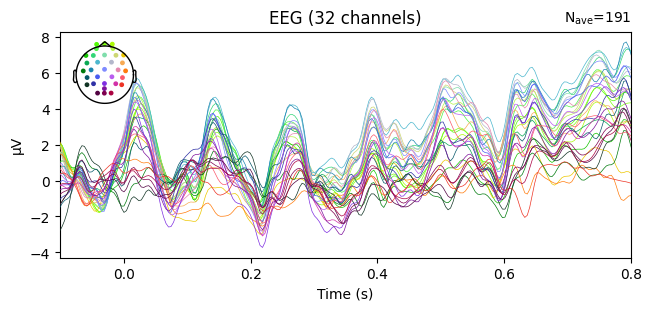

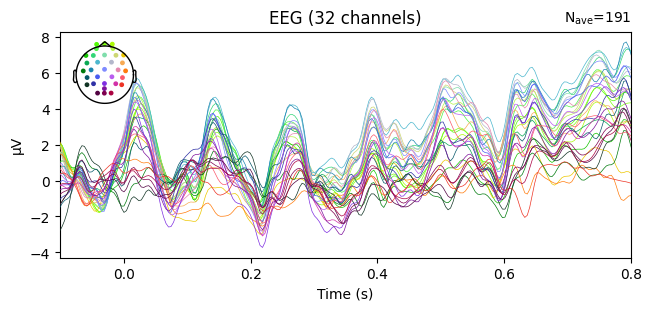

In [8]:
evokeds['jhana']['dev'][1].plot()

## Creating MMN

In [5]:
# Creating the evoked responses

evo_j_std = mne.combine_evoked(evokeds['jhana']['std'], weights='equal')
evo_j_dev = mne.combine_evoked(evokeds['jhana']['dev'], weights='equal')
evo_m_std = mne.combine_evoked(evokeds['mindfulness']['std'], weights='equal')
evo_m_dev = mne.combine_evoked(evokeds['mindfulness']['dev'], weights='equal')

evo_all_std = mne.combine_evoked([evo_j_std, evo_m_std], weights='equal')
evo_all_dev = mne.combine_evoked([evo_j_dev, evo_m_dev], weights='equal')
evo_all_all = mne.combine_evoked([evo_all_std, evo_all_dev], weights='nave')


## Visualizing MMNs and topo

overall global response


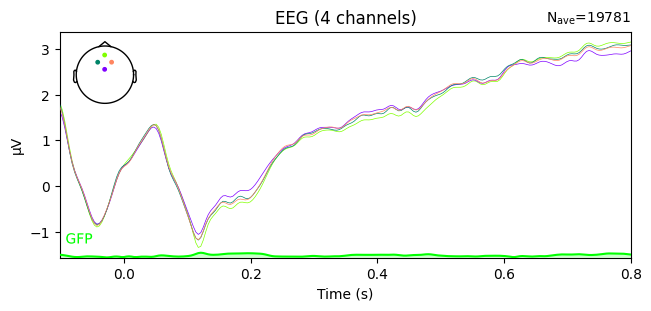

Global Evoked Response


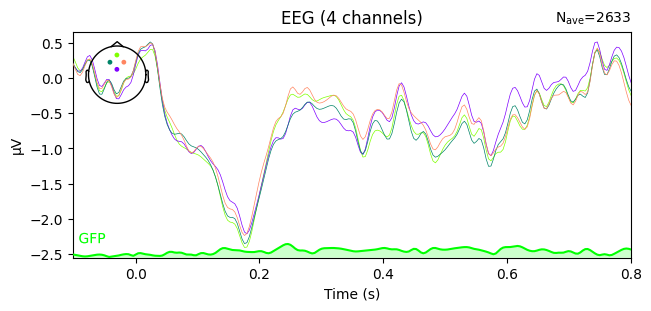

Jhana Evoked Response


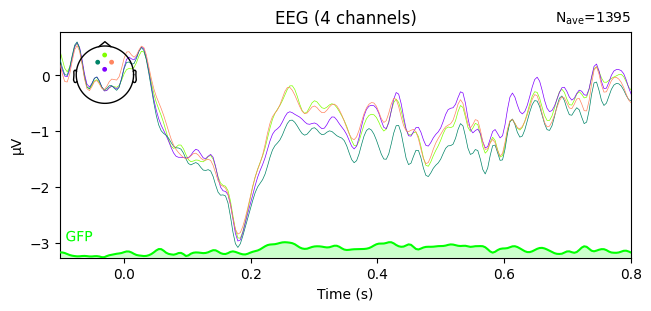

Mindfulnesss Evoked Response


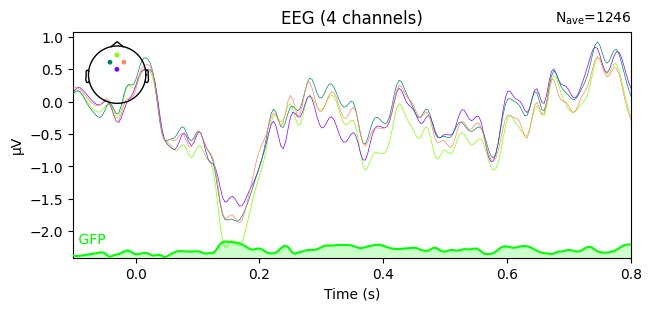

In [6]:
# Plotting the evoked responses for different conditions
print ('overall global response')
evo_all_all.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="overall global response", gfp=True, time_unit="s")

print('Global Evoked Response')
evo_diff = mne.combine_evoked([evo_all_dev, evo_all_std], weights=[1, -1])
evo_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Global Evoked Response", gfp=True, time_unit="s")

print('Jhana Evoked Response')
evo_j_diff = mne.combine_evoked([evo_j_dev, evo_j_std], weights=[1, -1])
evo_j_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Jhana Difference", gfp=True, time_unit="s")

print('Mindfulnesss Evoked Response')
evo_m_diff = mne.combine_evoked([evo_m_dev, evo_m_std], weights=[1, -1])
evo_m_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")

evo_jm_diff = mne.combine_evoked([evo_j_diff, evo_m_diff], weights=[1, -1])


# for sub in range(10):
#     print (30*"#")
#     print (f'MMN, Jhana, sub: {sub}')
#     evo_j_diff_sub = mne.combine_evoked([evokeds['jhana']['dev'][sub], evokeds['jhana']['std'][sub]], weights=[1, -1])
#     evo_j_diff_sub.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")

#     print (f'MMN, Mindfulness, sub: {sub}')
#     evo_m_diff_sub = mne.combine_evoked([evokeds['mindfulness']['dev'][sub], evokeds['mindfulness']['std'][sub]], weights=[1, -1])
#     evo_m_diff_sub.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")

print('')

## Helper functions for cluster permutation test

In [244]:
# function to cut the evokeds array

def cut_array(evokeds_array, start,end, channel_selection=None, channel_names=None):
    start_samp = int(np.round((start+0.1)*256))
    end_samp = int(np.round((end+0.1)*256))
    
    if channel_selection == None: 
        evokeds_array_t = evokeds_array[:,:,:,start_samp:end_samp, :]   
    else:
        channel_indices = [channel_names.index(ch) for ch in channel_selection if ch in channel_names]
        evokeds_array_t = evokeds_array[:,:,:,start_samp:end_samp, channel_indices]   
    return (evokeds_array_t)


In [8]:
# function to plot the cluster permutation results
time = np.linspace(-0.1, 0.8, 232)  # From -0.1s to 0.8s

def plot_cluster_permutation (time_series, time, title, clusters, start, end):
    
    plt.figure(figsize=(10, 6))
    for i in range(len(time_series)):
        plt.plot(time, time_series[i][0], label=time_series[i][1], linewidth=1, linestyle=time_series[i][2])
    

    for cluster in clusters:
        plt.axvspan(float(cluster[0][0]+start*256)/256, float(cluster[0][-1]+start*256)/256, color='yellow', alpha=0.3, label='cluster')
    
    plt.axvline(x=start, color='red', linestyle='--', linewidth=1)  # Example: vertical line at x=0
    plt.axvline(x=end, color='red', linestyle='--', linewidth=1)  # Example: vertical line at x=0

    
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amplitude (µV)', fontsize=14)  # µV is the common unit for EEG
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Cluster Permutation Tests

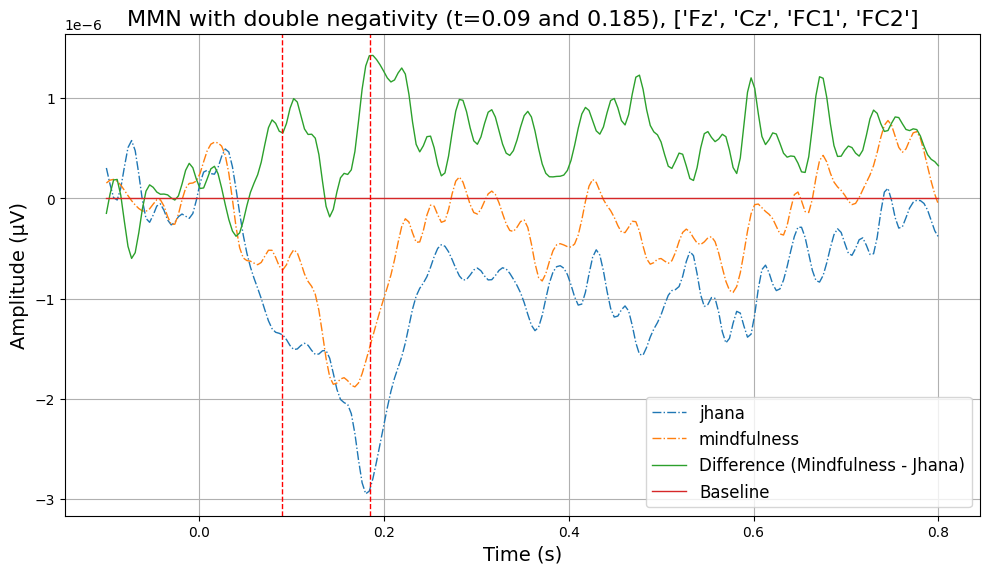

standard
[]


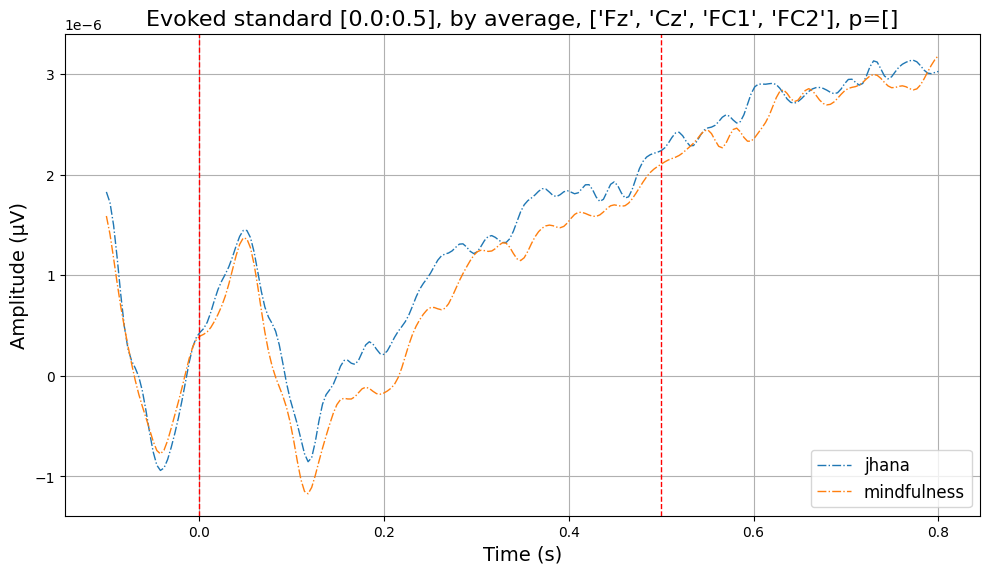

deviant
[]


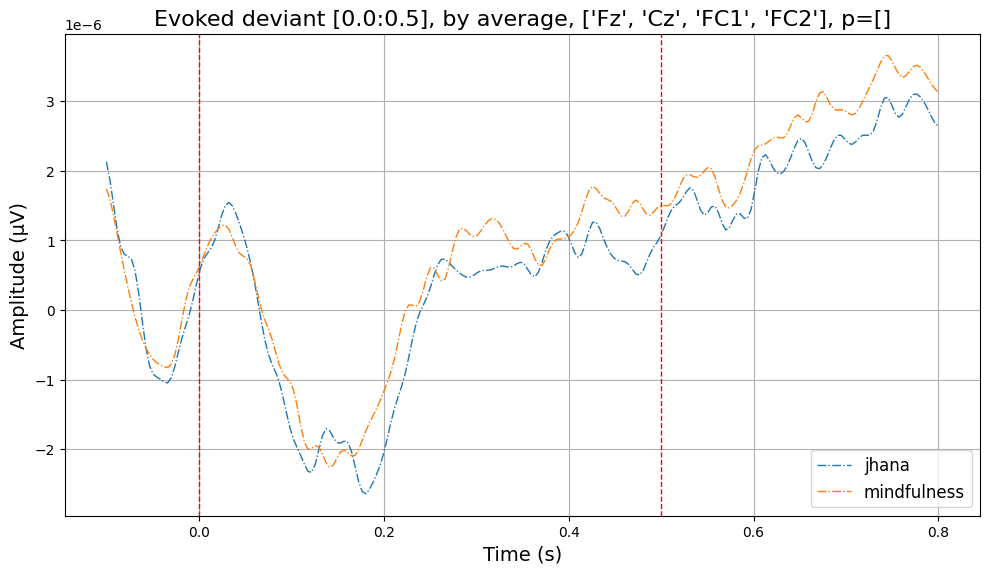

mmn
[0.82250977 0.17553711 0.56591797 0.67419434]


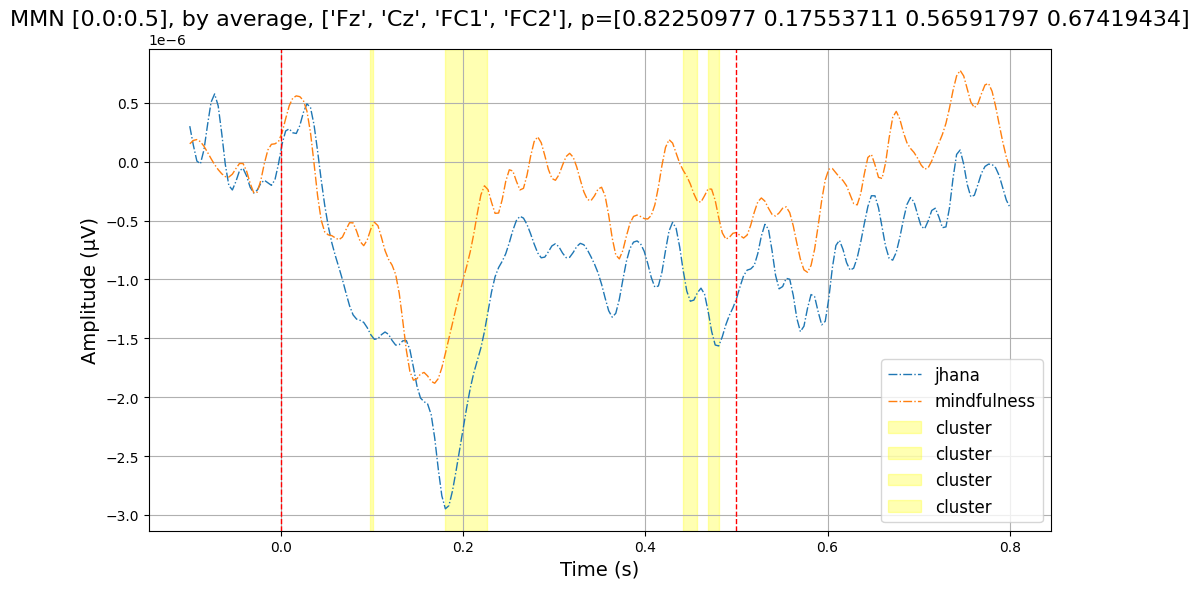

mmn
[0.47546387 0.07763672]


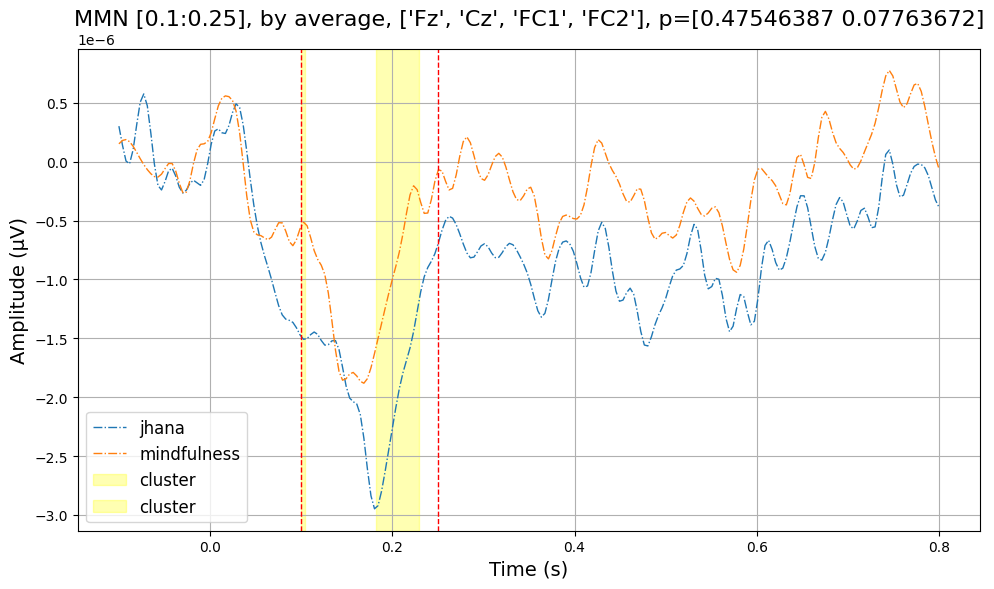

mmn
[0.04589844]


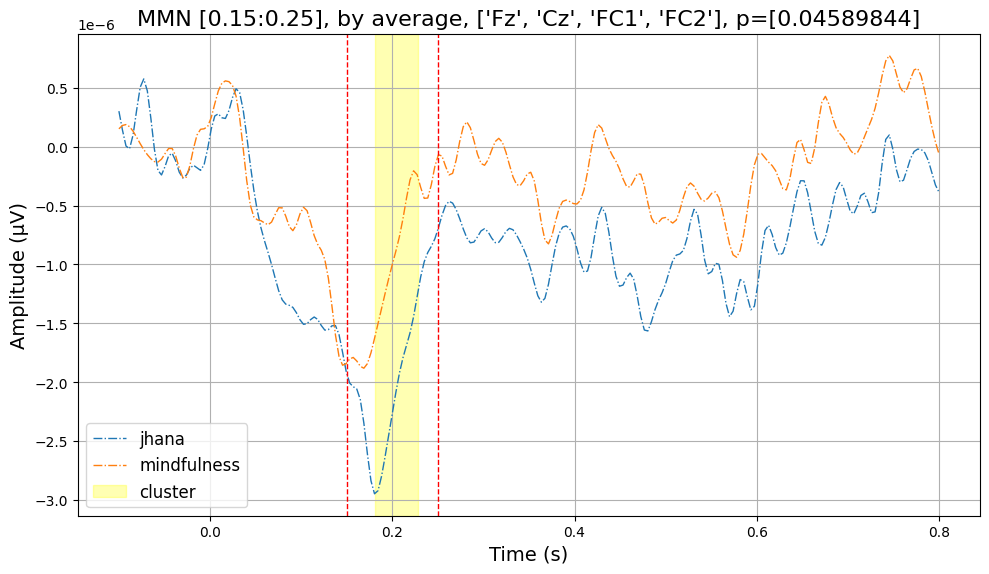

In [56]:
#############################
### Set up ###
#############################


# Create evokeds_array object
channel_selection = ['F7', 'F3', 'FC5']
channel_selection = ['Fz']
channel_selection = ['Fz', 'Cz', 'FC1', 'FC2']

evokeds_array = np.zeros([10,2,3,232,len(channel_selection)])
for sub in range(10):
    for meditation_n, meditation in enumerate(['jhana', 'mindfulness']):
        for condition_n, condition in enumerate(['std','dev','mmn']):
            evokeds_array[sub,meditation_n,condition_n,:,:] = evokeds[meditation][condition][sub].copy().pick_channels(channel_selection).get_data().T
mean_j = evokeds_array[:,0,2,:].mean(axis=0)
mean_m = evokeds_array[:,1,2,:].mean(axis=0)
mean_dif = mean_j - mean_m


average = True

if average:
    evokeds_array = evokeds_array.mean(axis=4, keepdims=True)
    average_info = 'by average'
else:
    average_info = 'by channel'





#############################
### RUN THE CODE ###
#############################


start = 0.0
end = 0.5

evokeds_array_t = cut_array(evokeds_array, start, end)

time_series = [
    [evokeds_array[:,0,2,:].mean(axis=(0,2)), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=(0,2)), 'mindfulness', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=(0,2))-evokeds_array[:,0,2,:].mean(axis=(0,2)), 'Difference (Mindfulness - Jhana)', '-'],
    [np.zeros(232), 'Baseline', '-']
]
plot_cluster_permutation (time_series, time, title=f'MMN with double negativity (t=0.09 and 0.185), {channel_selection}', clusters=[], start=0.09, end=0.185)


print('standard')
X =[evokeds_array_t[:,0,0,:], evokeds_array_t[:,1,0,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,0,:].mean(axis=(0,2)), 'jhana', 'dashdot'],
    [evokeds_array[:,1,0,:].mean(axis=(0,2)), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'Evoked standard [{start}:{end}], {average_info}, {channel_selection}, p={cluster_p_values}', clusters=clusters, start=start, end=end)

print('deviant')
X =[evokeds_array_t[:,0,1,:], evokeds_array_t[:,1,1,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,1,:].mean(axis=(0,2)), 'jhana', 'dashdot'],
    [evokeds_array[:,1,1,:].mean(axis=(0,2)), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'Evoked deviant [{start}:{end}], {average_info}, {channel_selection}, p={cluster_p_values}', clusters=clusters, start=start, end=end)

print('mmn')
X =[evokeds_array_t[:,0,2,:], evokeds_array_t[:,1,2,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,2,:].mean(axis=(0,2)), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=(0,2)), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'MMN [{start}:{end}], {average_info}, {channel_selection}, p={cluster_p_values}', clusters=clusters, start=start, end=end)


print('mmn')
start = 0.1
end = 0.25
evokeds_array_t = cut_array(evokeds_array, start, end)

X =[evokeds_array_t[:,0,2,:], evokeds_array_t[:,1,2,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,2,:].mean(axis=(0,2)), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=(0,2)), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'MMN [{start}:{end}], {average_info}, {channel_selection}, p={cluster_p_values}', clusters=clusters, start=start, end=end)


print('mmn')
start = 0.15
end = 0.25
evokeds_array_t = cut_array(evokeds_array, start, end)

X =[evokeds_array_t[:,0,2,:], evokeds_array_t[:,1,2,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,2,:].mean(axis=(0,2)), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=(0,2)), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'MMN [{start}:{end}], {average_info}, {channel_selection}, p={cluster_p_values}', clusters=clusters, start=start, end=end)


## Paired ttest (as per per registration)

In [264]:
"""
https://osf.io/t35s6/wiki/home/
For the MMN mean ERP components, we will average for the section 100ms to 250ms after stimulus onset, 
for the P3 component, we will average the section 250ms – 500ms after stimulus onset. 
"""
channel_selection = ['F7', 'F3', 'FC5']
channel_selection = ['Fz']
channel_selection = ['Fz', 'Cz', 'FC1', 'FC2']

start = 0.1
end = 0.25
evokeds_array_t = cut_array(evokeds_array, start, end, channel_selection, evo_jm_diff.ch_names)

a = evokeds_array_t[:,0,2,:,:].mean(axis=(1,2))
b = evokeds_array_t[:,1,2,:,:].mean(axis=(1,2))
print (ttest_rel(a, b))

start = 0.25
end = 0.5
evokeds_array_t = cut_array(evokeds_array, start, end, channel_selection, evo_jm_diff.ch_names)

a = evokeds_array_t[:,0,2,:,:].mean(axis=(1,2))
b = evokeds_array_t[:,1,2,:,:].mean(axis=(1,2))
print (ttest_rel(a, b))

TtestResult(statistic=np.float64(-2.4463818023456265), pvalue=np.float64(0.036975530059599054), df=np.int64(9))
TtestResult(statistic=np.float64(-1.574541107017463), pvalue=np.float64(0.14981474561755304), df=np.int64(9))


## Cluster based permutation test

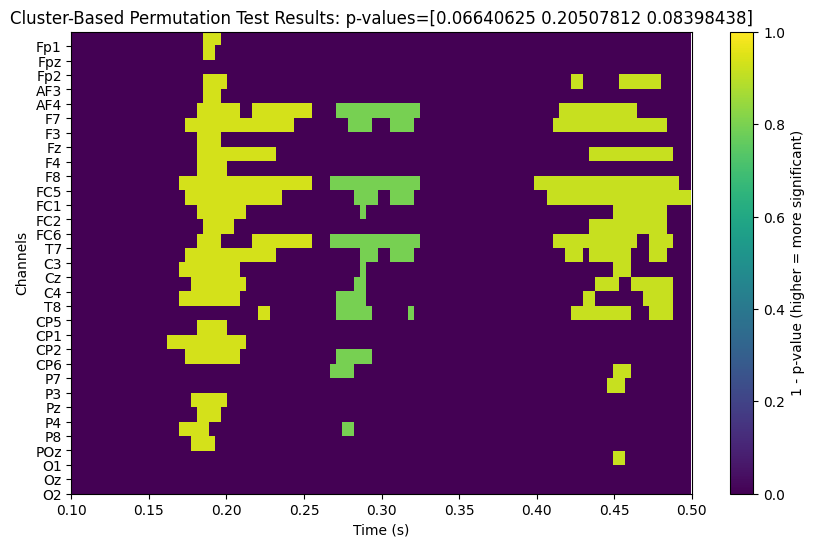

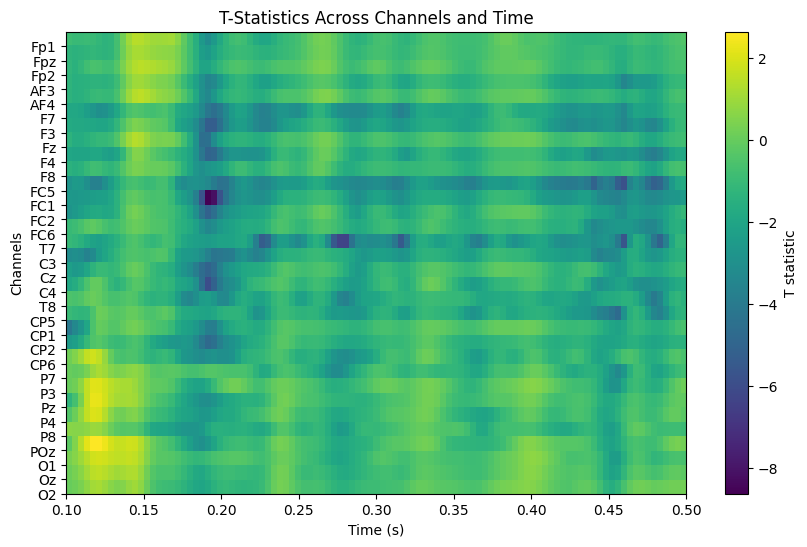

significant_indices:
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


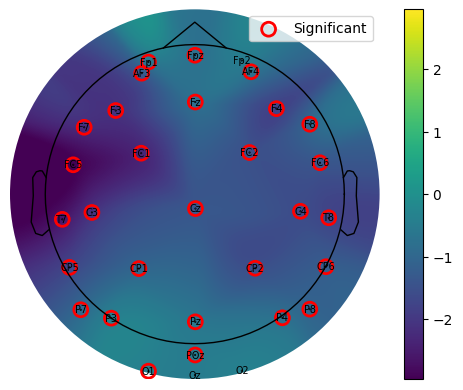

In [265]:
start = 0.1
end = 0.5
p_threshold = 0.3

ch_adjacency, channel_selection = mne.channels.find_ch_adjacency(evokeds['jhana']['std'][0].info, 'eeg')

evokeds_array = np.zeros([10,2,3,232,len(channel_selection)])
for sub in range(10):
    for meditation_n, meditation in enumerate(['jhana', 'mindfulness']):
        for condition_n, condition in enumerate(['std','dev','mmn']):
            evokeds_array[sub,meditation_n,condition_n,:,:] = evokeds[meditation][condition][sub].copy().pick_channels(channel_selection).get_data().T
mean_j = evokeds_array[:,0,2,:].mean(axis=0)
mean_m = evokeds_array[:,1,2,:].mean(axis=0)
mean_dif = mean_j - mean_m

evokeds_array_t = cut_array(evokeds_array, start, end)

#X =[evokeds_array_t[:,0,2,:], evokeds_array_t[:,1,2,:]]
#threshold_tfce = dict(start=0.2, step=0.5)
#T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=None, n_permutations=8192)

X_diff = evokeds_array_t[:,0,2,:] - evokeds_array_t[:,1,2,:]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    X_diff, threshold=None, n_permutations=8192, tail=0, adjacency=ch_adjacency
)




time_series = [
    [evokeds_array[:,0,2,:].mean(axis=(0,2)), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=(0,2)), 'mindfulness', 'dashdot'],
]

#plot_cluster_permutation (time_series, time, title=f'MMN [{start}:{end}], {average_info}, {channel_selection}, p={cluster_p_values}', clusters=clusters, start=start, end=end)



###########################
### 2D Plot of clusters ###
###########################


# Input variables: T_obs, clusters, cluster_p_values
n_channels, n_times = T_obs.T.shape

# Define the sampling rate and time window
sampling_rate = 256  # Hz

# Calculate time points in seconds
times = np.linspace(start, end, n_times)

# Initialize a 2D matrix for visualization
cluster_matrix = np.zeros((n_channels, n_times))

# Populate the matrix with cluster p-values
for i, cluster in enumerate(clusters):
    p_val = cluster_p_values[i]
    if p_val < p_threshold:  # Only include significant clusters
        for t, ch in zip(cluster[0], cluster[1]):
            cluster_matrix[ch, t] = 1 - p_val  # Higher intensity for smaller p-values

# Create the plot
plt.figure(figsize=(10, 6))
norm = Normalize(vmin=0, vmax=1)  # Normalize values between 0 and 1
plt.imshow(cluster_matrix, 
           aspect='auto', 
           cmap='viridis', 
           norm=norm,
           origin='upper', 
           extent=[times[0], times[-1], 0, n_channels])

# Add channel labels
plt.yticks(ticks=np.arange(n_channels), labels=channel_selection[::-1])

# Add colorbar for p-value gradient
cbar = plt.colorbar()
cbar.set_label("1 - p-value (higher = more significant)")

# Label axes
selected_cluster_p = cluster_p_values[cluster_p_values<p_threshold]
plt.title(f"Cluster-Based Permutation Test Results: p-values={selected_cluster_p}")
plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.show()



##########################
### 2D Plot of T-Stats ###
##########################


# Input variables: T_obs
n_channels, n_times = T_obs.T.shape
sampling_rate = 256  # Hz

# Calculate time points in seconds
times = np.linspace(start, end, n_times)


# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(T_obs.T, aspect='auto', 
           #cmap='coolwarm', 
           origin='upper',
           extent=[times[0], times[-1], 0, n_channels])

plt.yticks(ticks=np.arange(n_channels), labels=channel_selection[::-1])

cbar = plt.colorbar()
cbar.set_label("T statistic")

# Label axes
plt.title("T-Statistics Across Channels and Time")
plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.show()





################################
### Find significant indices ###
################################

channel_selection = evokeds['jhana']['std'][0].ch_names

# Find significant clusters
significant_clusters = np.where(cluster_p_values < p_threshold)[0]

# Extract significant channel indices
significant_channels = []  # Use a set to avoid duplicates
for cluster_idx in significant_clusters:
    cluster = clusters[cluster_idx]    
    significant_channels.append(cluster[1])

significant_indices = np.unique(np.concatenate(significant_channels))
print ('significant_indices:')
print(significant_indices)

######################
### Plot topo maps ###
######################

# get positions for topo maps:
montage = mne.channels.make_standard_montage('standard_1020')
selected_channels = [ch for ch in montage.ch_names if ch in channel_selection]
selected_positions = np.array([montage.get_positions()['ch_pos'][ch][:2] for ch in selected_channels])


fig, ax = plt.subplots()
im, _ = plot_topomap(
    T_obs.mean(axis=0), 
    pos=selected_positions, 
    names=channel_selection,
    axes=ax,
    cmap='viridis', 
    contours=0,
    show=False  # Prevent automatic display
)

# Overlay significant channels with bold markers
for idx in significant_indices:
    ax.scatter(
        selected_positions[idx, 0], 
        selected_positions[idx, 1], 
        s=100,  # Marker size
        edgecolor='red',  # Outline color
        facecolor='none',  # Hollow circle
        linewidth=2,  # Line thickness for boldness
        label='Significant' if idx == significant_indices[0] else None  # Add label only once
    )

# Add legend for significant channels
ax.legend(loc='upper right')

# Display the plot
plt.colorbar(im, ax=ax)
plt.show()


## Topo maps 

evo_j_std


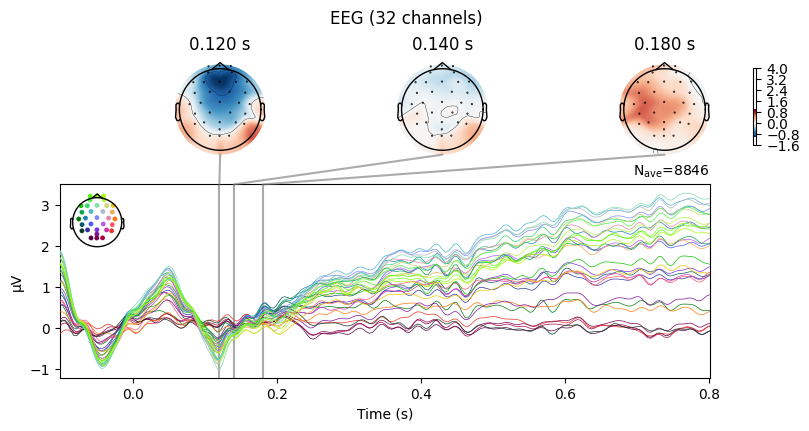

evo_m_std


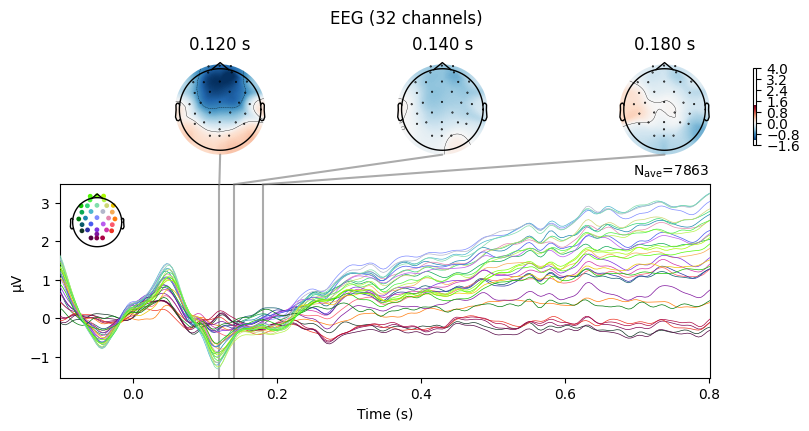

evo_j_dev


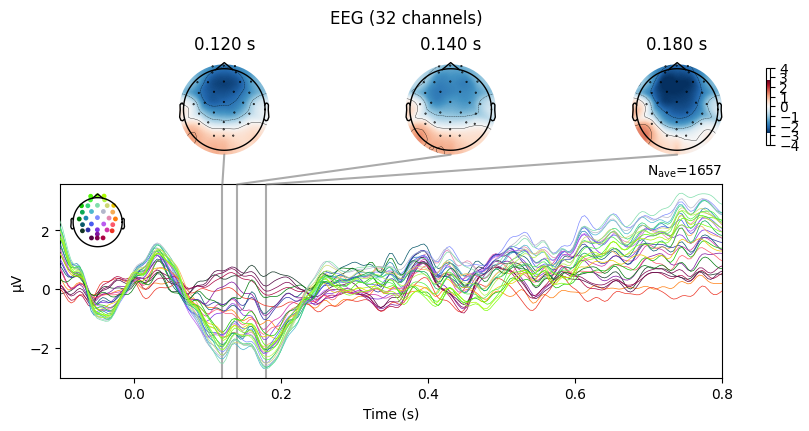

evo_m_dev


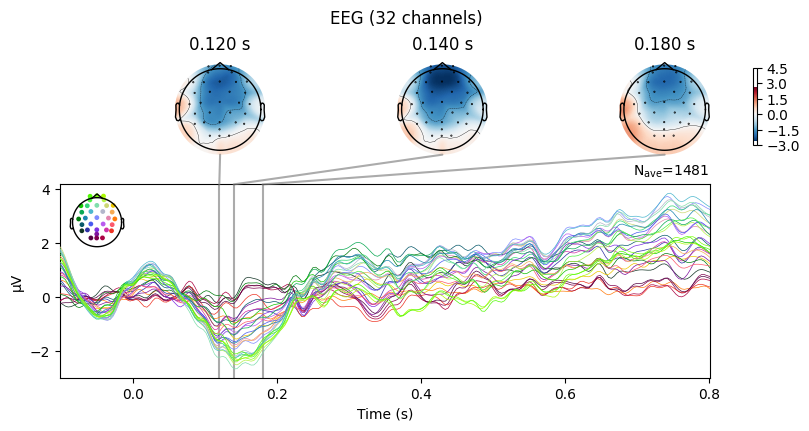

evo_j_diff


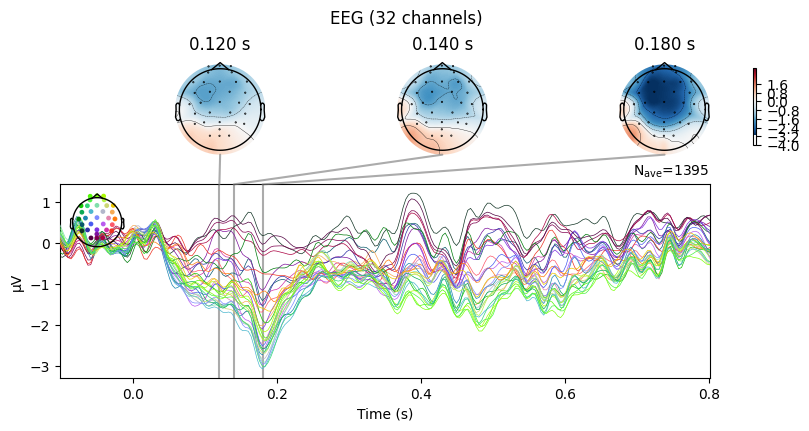

evo_m_diff


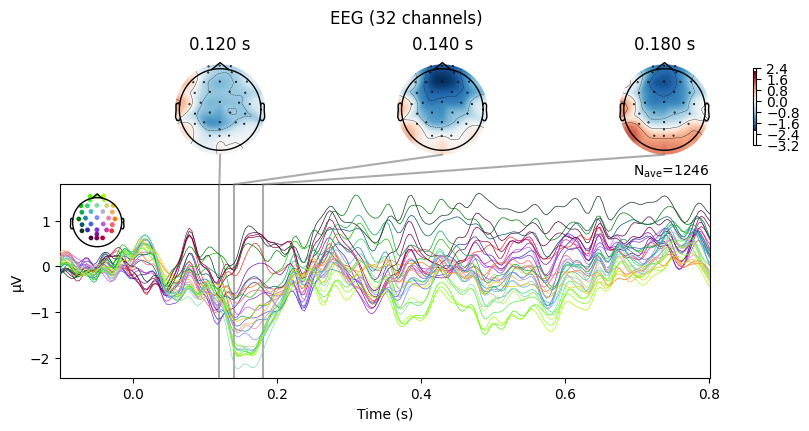

evo_jm_diff


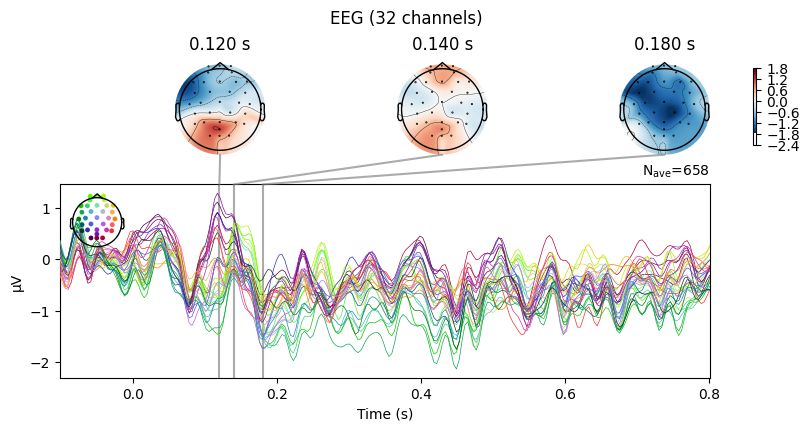

In [21]:
print('evo_j_std')
evo_j_std.plot_joint(times=[0.12, 0.14, 0.18])
print('evo_m_std')
evo_m_std.plot_joint(times=[0.12, 0.14, 0.18])

print('evo_j_dev')
evo_j_dev.plot_joint(times=[0.12, 0.14, 0.18])
print('evo_m_dev')
evo_m_dev.plot_joint(times=[0.12, 0.14, 0.18])

print('evo_j_diff')
evo_j_diff.plot_joint(times=[0.12, 0.14, 0.18])
print('evo_m_diff')
evo_m_diff.plot_joint(times=[0.12, 0.14, 0.18])

print('evo_jm_diff')
evo_jm_diff.plot_joint(times=[0.12, 0.14, 0.18])

print ('')
# change the 0.235

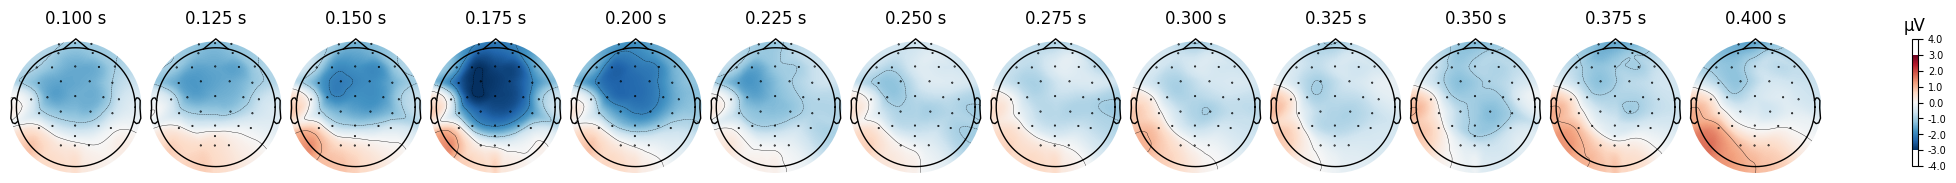

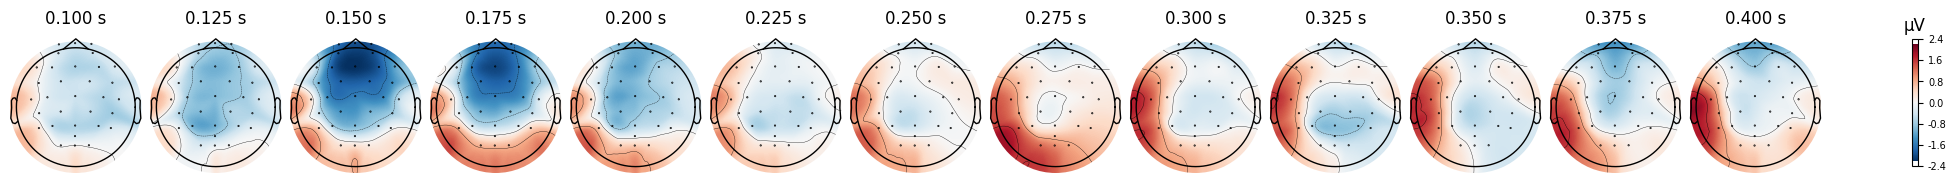

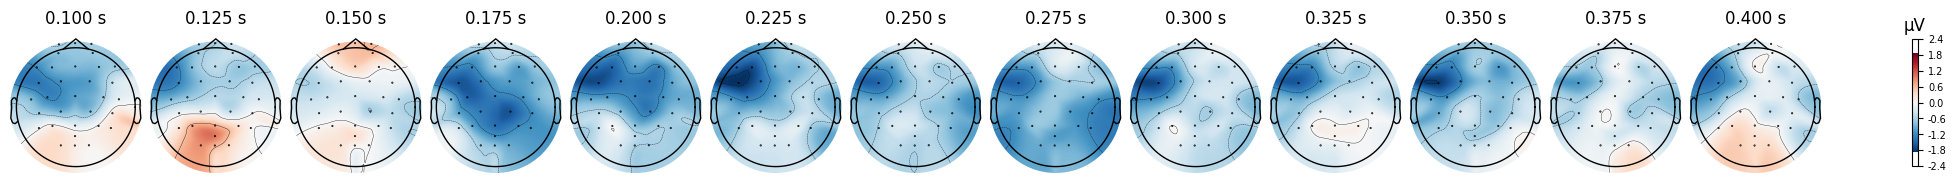

In [22]:
time_points = np.arange(0.1, 0.401, 0.025)  # Time in seconds

for evo in [evo_j_diff, evo_m_diff, evo_jm_diff]:
    evo.plot_topomap(
        times=time_points
    )

print ('')

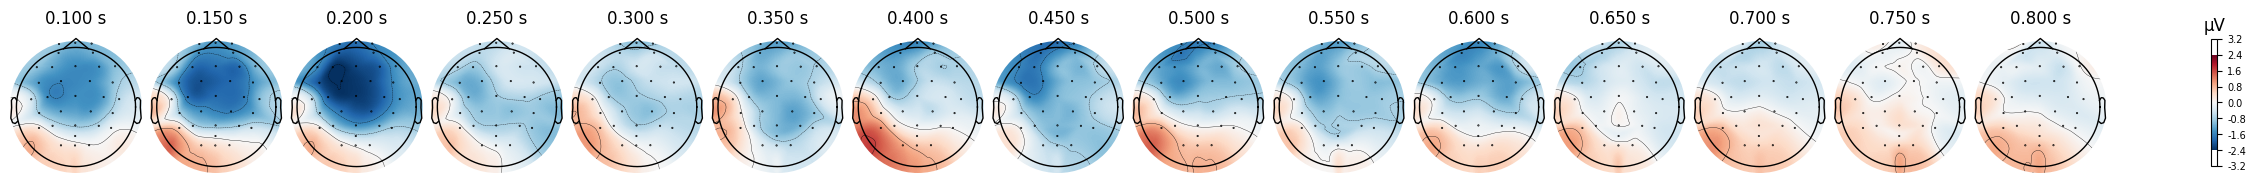

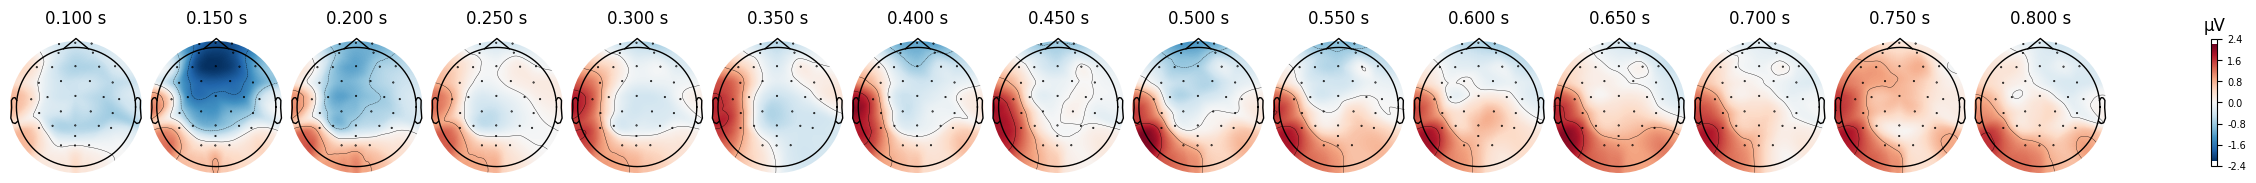

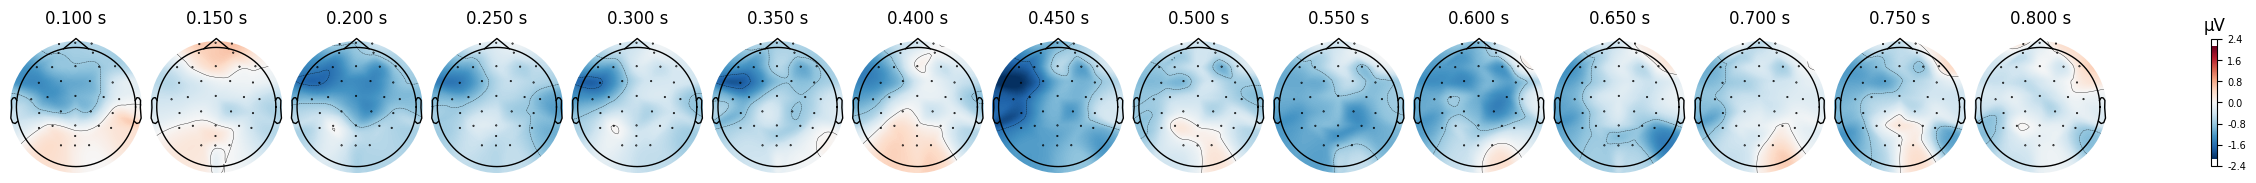

In [23]:
time_points = np.arange(0.1, 0.81, 0.05)  # Time in seconds

for evo in [evo_j_diff, evo_m_diff, evo_jm_diff]:
    evo.plot_topomap(
        times=time_points
    )

print ('')